In [171]:
import numpy as np
import pandas as pd
import datetime

from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

pd.options.display.max_columns = 300

In [172]:
df_train = pd.read_csv('../input/20181216_train.csv')
df_test = pd.read_csv('../input/20181216_test.csv')

In [173]:
df_train['dataset_flag'] = 0
df_test['dataset_flag'] = 1

In [174]:
def merge_new_feature(path, use=[]):
    if len(use) > 1:
        df_new_feature = pd.read_csv(path, usecols=use)
    else:
        df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [175]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/payment_splited_by_installments_NMF.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")

In [176]:
dont_use = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'category_1_Y_std', 'dataset_flag']

df_train_columns = [c for c in df_train.columns if c not in dont_use]

In [177]:
max_each_col = np.max(df_train[df_train_columns].values, axis=0)

for i, max_ in enumerate(max_each_col):
    if max_ >= 1e+7:
        df_train[df_train_columns[i]] = 1/(1+np.exp(-1*df_train[df_train_columns[i]].values))
        df_test[df_train_columns[i]] = 1/(1+np.exp(-1*df_test[df_train_columns[i]].values))

In [178]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.962:
        drop_col.append(c2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

In [179]:
df_whole = pd.concat([df_train, df_test], axis=0)
df_tr, df_te = train_test_split(df_whole, test_size=0.2, random_state=1000, shuffle = True)

df_tr = df_tr.reset_index(drop=True)
df_te = df_te.reset_index(drop=True)

target = df_tr.dataset_flag

In [180]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'binary',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_tr))
predictions = np.zeros(len(df_te))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_tr, df_tr.dataset_flag)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_tr.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_tr.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_tr.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_te[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(df_te.dataset_flag, predictions)

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.613843	valid_1's auc: 0.499167
Early stopping, best iteration is:
[54]	training's auc: 0.593678	valid_1's auc: 0.500846
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.622178	valid_1's auc: 0.503439
Early stopping, best iteration is:
[4]	training's auc: 0.533393	valid_1's auc: 0.505512
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.623087	valid_1's auc: 0.505124
[200]	training's auc: 0.65858	valid_1's auc: 0.505969
Early stopping, best iteration is:
[150]	training's auc: 0.641595	valid_1's auc: 0.508198
fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.625696	valid_1's auc: 0.503085
Early stopping, best iteration is:
[15]	training's auc: 0.560368	valid_1's auc: 0.507153
fold 4
Training until validation scores don't improve for 100 rounds.
[100]	training's auc

0.4983065160459993

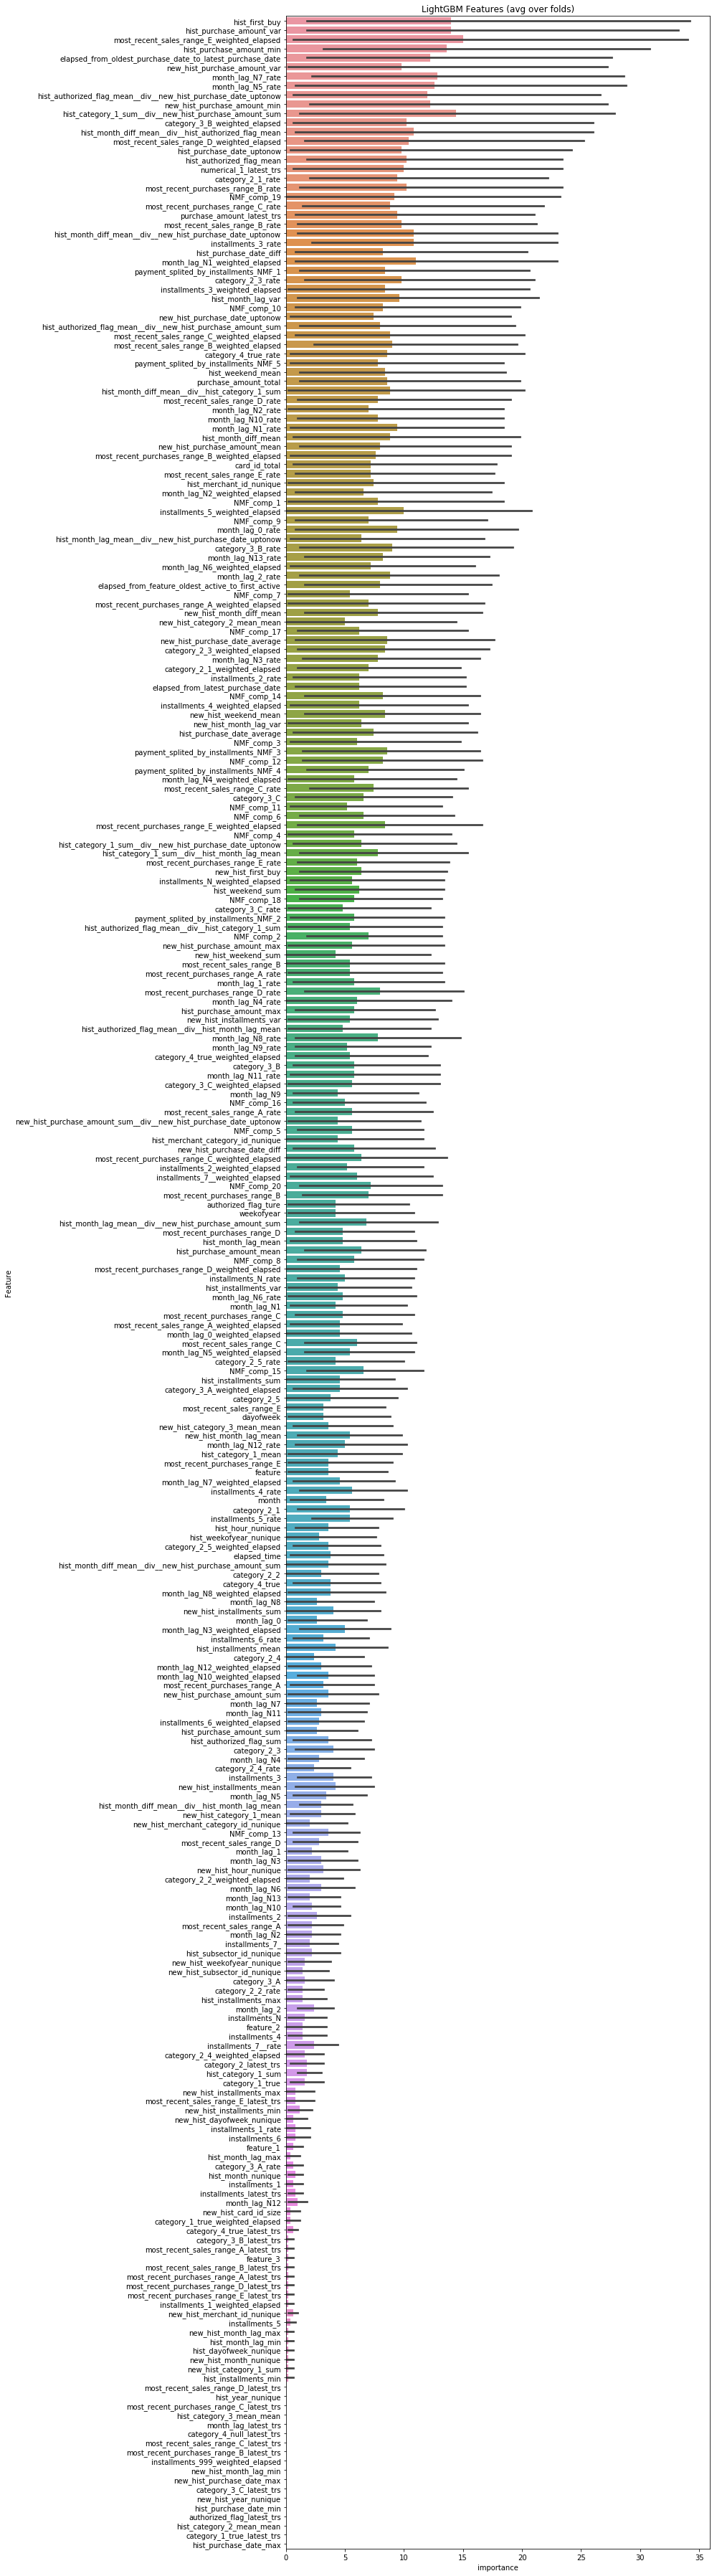

In [181]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()